In [1]:
using IterTools

using CSV
using DataFrames
using LinearAlgebra
using SpecialFunctions
using GraphPlot
using GraphRecipes, Plots
using Graphs, SimpleWeightedGraphs
using Distributions

using DataStructures

# Data structures

In [2]:
struct Variable
    name::Symbol
    m::Int # number of possible values
end

const Assignment = Dict{Symbol,Int}
const FactorTable = Dict{Assignment,Float64}

struct Factor
    vars::Vector{Variable}
    table::FactorTable
end

struct BayesianNetwork
    vars::Vector{Variable}
    factors::Vector{Factor}
    graph::SimpleDiGraph{Int64}
end


struct K2Search
    ordering::Vector{Int} # variable ordering
end


struct LocalDirectedGraphSearch
    G # initial graph
    k_max # number of iterations
end



# Auxiliar methods

In [59]:
variablenames(ϕ::Factor) = [var.name for var in ϕ.vars]
select(a::Assignment, varnames::Vector{Symbol}) = Assignment(n=>a[n] for n in varnames)
    

function assignments(vars::AbstractVector{Variable})
    names = [var.name for var in vars]
    return vec([Assignment(n=>v for (n,v) in zip(names, values)) for values in product((1:v.m for v in vars)...)])
end



function sub2ind(siz, x)
    k = vcat(1, cumprod(siz[1:end-1]))
    return dot(k, x .- 1) + 1
end



function statistics(vars, G, D::Matrix{Int})
    n = size(D, 1)
    r = [vars[i].m for i in 1:n]
    q = [prod([r[j] for j in inneighbors(G,i)]) for i in 1:n]
    
    M = [zeros(q[i], r[i]) for i in 1:n]
    
    for o in eachcol(D)
        for i in 1:n
            k = o[i]
            parents = inneighbors(G,i)
            j = 1
            
            
#             println("parents:",parents,"===",i)
            if !isempty(parents)
                j = sub2ind(r[parents], o[parents])
            end
            
            
            try
                M[i][j,k] += 1.0
            catch
                print(" ")
            end
            
        end
    end
    
    return M
end



function prior(vars, G)
    n = length(vars)
    r = [vars[i].m for i in 1:n]
    q = [prod([r[j] for j in inneighbors(G,i)]) for i in 1:n]
    return [ones(q[i], r[i]) for i in 1:n]
end



prior (generic function with 1 method)

In [4]:
function bayesian_score_component(M, α)
    p = sum(loggamma.(α + M))
    p -= sum(loggamma.(α))
    p += sum(loggamma.(sum(α,dims=2)))
    p -= sum(loggamma.(sum(α,dims=2) + sum(M,dims=2)))
    return p
end



function bayesian_score(vars, G, D)
    n = length(vars)
    M = statistics(vars, G, D)
    α = prior(vars, G)
    return sum(bayesian_score_component(M[i], α[i]) for i in 1:n)
end

bayesian_score (generic function with 1 method)

# Algoritmo Hill Climbing Aleatorio

In [5]:
function rand_graph_neighbor(G)
    n = nv(G)
    i = rand(1:n)
    j = mod1(i + rand(2:n)-1, n)
    G′ = copy(G)
    has_edge(G, i, j) ? rem_edge!(G′, i, j) : add_edge!(G′, i, j)
    return G′
end

function fit(method::LocalDirectedGraphSearch, vars, D)
    G = method.G
    y = bayesian_score(vars, G, D)
    println("Initial;",y)
    for k in 1:method.k_max
        G′ = rand_graph_neighbor(G)
        y′ = is_cyclic(G′) ? -Inf : bayesian_score(vars, G′, D)
        
        if y′ > y
            y, G = y′, G′
            println(y)
        end
        
        
    end
    return G
end

fit (generic function with 1 method)

# Algoritmo K2

In [6]:
function fit(method::K2Search, vars, D)
    G = SimpleDiGraph(length(vars))
    for (k,i) in enumerate(method.ordering[2:end])
        y = bayesian_score(vars, G, D)
        while true
            y_best, j_best = -Inf, 0
            for j in method.ordering[1:k]
                if !has_edge(G, j, i)                 # no tiene arista
                    add_edge!(G, j, i)                # Agrega arista 
                    y′ = bayesian_score(vars, G, D)   
                    if y′ > y_best
                        y_best, j_best = y′, j
                    end
                    rem_edge!(G, j, i)                # remueve arista
                end
            end
            if y_best > y
                    y = y_best
                    add_edge!(G, j_best, i)
                println("Bayesian score: ",y_best)
            else
                    break
            end
        end
    end
    return G
end

fit (generic function with 2 methods)

# Algorithm: Hill Climbing with restricted edges

In [7]:
function rand_graph_neighbor(G, directed_edges,tested)
    G′ = copy(G)
    
    directed_edges_1, possible, tested_copy = directed_edges,[],copy(tested)

    for e in edges( G′)
        tuple=(e.src,e.dst)

        if tuple in directed_edges_1
            continue
        end

        push!(possible, tuple)
    end


    tuple=(0,0)
    
    for edge in possible
        if edge in tested
            continue
        end
        tuple = edge
    end

    if tuple==(0,0)
        return  G′, tested_copy
    end

    push!(tested_copy,tuple)

    rem_edge!( G′, tuple[1], tuple[2])
    add_edge!( G′, tuple[2], tuple[1])

    println(tested_copy)

    return G′, tested_copy
end


function fit(method::LocalDirectedGraphSearch, vars, D, directed_edges)
    G = method.G
    y = bayesian_score(vars, G, D)
    println("Initial;",y)
    
    count_iterations = 0
    tested = []
    
    for k in 1:method.k_max
        
        G′,tested = rand_graph_neighbor(G,directed_edges,tested)
        y′ = is_cyclic(G′) ? -Inf : bayesian_score(vars, G′, D)
        
        if y′ > y
            y, G = y′, G′
            
        end
        
    end
    
    println("Final: ",y)
    
    return G
end

fit (generic function with 3 methods)

# Algorithm: Tree learning  

C. Chow and C. Liu, "Approximating discrete probability distributions with dependence trees," in IEEE Transactions on Information Theory, vol. 14, no. 3, pp. 462-467, May 1968, doi: 10.1109/TIT.1968.1054142.

1.- Creating a dictionary with a tuple as a key. The tuple will indicate which is the pair of variables being evaluated, the value will represent the mutual information metric.

In [8]:
# Params:
#  variables must be vector
# Return:
#  Dictionary (Tuple, Float64) with pairings between variables

function fill_dictionary(variables)
    result_dict = Dict{Tuple, Float64}()
    variables_i = variables
    for (i,var_i) in enumerate(variables_i)
        for (j,var_j) in enumerate(variables_i)
            if var_j == var_i
                continue
            elseif haskey(result_dict,(var_i,var_j)) || haskey(result_dict,(var_j,var_i))
                continue
            end
            push!(result_dict,(var_i,var_j)=>0)
        end
    end
    
    return result_dict
end

fill_dictionary (generic function with 1 method)

2.- Compute relative frecuency for every variable value

In [9]:
# Params:
#  var_1 - Vector with all the observations for variable 1
#  var_2 - Vector with all the observations for variable 1
#  tuple - Tuple with the two variables to evaluate

# Return:
#  Dictionary (Tuple, Int) with countings for every posible pair 
function pair_counter(var_1,var_2, tuple)
    data_var_1, data_var_2 = var_1, var_2
    
    val_1 = tuple[1]
    val_2 = tuple[2]
    
    result = Dict{Tuple, Int}()
    for i in 1:val_1.m
        for j in 1:val_2.m
            if haskey(result,(i,j))
                continue
            else
                 push!(result,(i,j)=>0)
            end
        end
    end
    
    for i in 1:length(data_var_1)
        result[(data_var_1[i],data_var_2[i])]+=1
    end
    
    return result
end


pair_counter (generic function with 1 method)

3.- Computing Mutual Information metric

In [10]:
# Params:
#  data  - Matrix nxm with dataset. n Represent the variable, m the observations
#  vars  - Array of Variables dtatype. It contains the name of the variables and the possible values. 
#          The positions in this arrays correspond to the position of the variables in the dataset (data)
#  dict  - Dictionary (Tuple, Float64) with pairings between variables

# Return:
#  Dictionary (Tuple, Float64) with pairings between variables. Tuple represent the pair of variables
function get_mutual_information(data, vars, dict)
    main_data = data
    pair_dict = dict
    
    vars_accumulator = Dict{Variable, Dict}()
    vars_position = Dict{Variable,Int}()
    n = size(main_data,2)
    
    
    # Compute accumulators
    for (i,var) in enumerate(vars)
        push!(vars_accumulator, var => counter(main_data[i,:]))
        push!(vars_position, var => i)
    end
    
    # Compute mutual information
    for (key,value) in pair_dict
        val_1 = main_data[vars_position[key[1]],:]
        val_2 = main_data[vars_position[key[2]],:]
        
        values_counter = pair_counter(val_1,val_2,key)
        
        mutual_information = sum( (values_counter[i_key]/n)*log(10, (vars_accumulator[key[1]])[i_key[1]]/n) / ((vars_accumulator[key[2]])[i_key[2]]/n) for i_key in keys(values_counter))

        pair_dict[key] = mutual_information
    end
    
    return pair_dict
end
    

get_mutual_information (generic function with 1 method)

4.- Creating a Maximum spanning tree with Mutual Information as metric

In [11]:
# Given an array and an element returns the position
function get_index(array,element)
    return findall(x->x==element, array)[1]
end



# Params:
#  vars  - Array of Variables dtatype. It contains the name of the variables and the possible values. 
#          The positions in this arrays correspond to the position of the variables in the dataset (data)
#  dict  - Dictionary (Tuple, Float64) with pairings between variables as key and mutual information as value

# Return:
#  Undirected Graph
function create_graph(dict,vars)
    
    mutual_information_dict = dict 
    graph = SimpleWeightedGraph(length(vars))
    
    mutual_information_dict = sort(mutual_information_dict, byvalue=true, rev=true)
    
    for (key,value) in mutual_information_dict
        edge_1,edge_2 = get_index(vars,key[1]), get_index(vars,key[2])
    
        add_edge!(graph,edge_1,edge_2,value)
    end
    
    g_mst = SimpleWeightedGraph(size(graph)[1]) #Create a new graph
    for ew in kruskal_mst(graph, minimize=false)
#         println(ew.src,"->",ew.dst)
       add_edge!(g_mst,ew.src,ew.dst,ew.weight)
    end
    
    return g_mst
end

create_graph (generic function with 1 method)

# Statistical test to find independant variables given an undirected grph structure

Chi-square independence test for trees

In [12]:
# Description:
#    Function that creates a contigency table for chi square test
# Params:
#    data  - Matrix nxm with dataset. n Represent the variable, m the observations
#    vars  - Array of Variables dtatype. It contains the name of the variables and the possible values. 
#            The positions in this arrays correspond to the position of the variables in the dataset (data)
#    var_1 - Variable datatype. Refers to a variable to be evaluated for an independence test 
#    var_2 - Variable datatype. Refers to a variable to be evaluated for an independence test 

# Return:
#    contigency_matrix_expected: Contegency matrix with expected values
#    contigency_matrix_observed: Contegency matrix with observated values
function get_contigency(data,vars,var_1,var_2)
    main_data = data
    vars_array = vars
    
    vars_position = Dict{Variable,Int}()
    n = size(main_data,2)
    
    for (i,var) in enumerate(vars)
        push!(vars_position, var => i)
    end
    
    val_1 = main_data[vars_position[var_1],:]
    val_2 = main_data[vars_position[var_2],:]
        
    values_counter = pair_counter(val_1,val_2,(var_1,var_2))
    
    rows = var_1.m+1
    cols = var_2.m+1
    contigency_matrix_observed = zeros(Float64, rows, cols)
    
    for (key,value) in values_counter
        contigency_matrix_observed[key[1],key[2]]=value
    end
    
    contigency_matrix_observed[rows,:]=sum(contigency_matrix_observed,dims=1)
    contigency_matrix_observed[:,cols]=sum(contigency_matrix_observed,dims=2)

    contigency_matrix_expected=copy(contigency_matrix_observed)
    
    total=contigency_matrix_expected[rows,cols]
    for i in 1:rows-1
        for j in 1:cols-1
            contigency_matrix_expected[i,j]= (contigency_matrix_expected[i,cols]*contigency_matrix_expected[rows,j])/total
        end
    end
    
    return contigency_matrix_expected, contigency_matrix_observed
end



# Description:
#    Return the statistic value given 
# Params:
#    data  - Matrix nxm with dataset. n Represent the variable, m the observations
#    vars  - Array of Variables dtatype. It contains the name of the variables and the possible values. 
#            The positions in this arrays correspond to the position of the variables in the dataset (data)
#    var_1 - Variable datatype. Refers to a variable to be evaluated for an independence test 
#    var_2 - Variable datatype. Refers to a variable to be evaluated for an independence test 
#    
# Return:
#    Int. Represent the statistic value
function get_statistic(expected,observed)
    _expected, _observed = expected, observed
    
    rows,cols=size(_expected)
    
    statistics_matrix = ((_expected.-_observed).^2)./_expected
    
    return sum(sum(statistics_matrix,dims=1),dims=2)[1]
    
end


# Description:
#    Hypothesis test: The variables var_1 and var_2 are independent 
# Params:
#    data  - Matrix nxm with dataset. n Represent the variable, m the observations
#    vars  - Array of Variables dtatype. It contains the name of the variables and the possible values. 
#            The positions in this arrays correspond to the position of the variables in the dataset (data)
#    var_1 - Variable datatype. Refers to a variable to be evaluated for an independence test 
#    var_2 - Variable datatype. Refers to a variable to be evaluated for an independence test 
#    α     - Trust value
# Return:
#    Boolean. True if variables are independant, False otherwise
function is_independent(data,vars,var_1,var_2,α)
    contigency_matrix_expected, contigency_matrix_observed = get_contigency(data,vars,var_1,var_2)
    
    statistic = get_statistic(contigency_matrix_expected,contigency_matrix_observed)
    
    # Calculate fredom degrees
    freedom_degree = (var_1.m-1) * (var_2.m-1)
    
    χ=cquantile(Chisq(4), 0.05) 
    
    if statistic > χ
        return false
    else
        return true   # Independents
    end
    
end


is_independent (generic function with 1 method)

In [13]:
# Description:
#    Search for multiparent nodes and evaluate if the parent are independant. Return pairs of vertex that are independant 
#    according to the chi square test 
# Params:
#    data  - Matrix nxm with dataset. n Represent the variable, m the observations
#    vars  - Array of Variables dtatype. It contains the name of the variables and the possible values. 
#            The positions in this arrays correspond to the position of the variables in the dataset (data)
#    graph - Undirected graph with a tree structure
# Return:
#    Dictionary (Tuple, Float64). Tuple represent two vertex that are fully independant

function get_independent_edges(data,vars,graph)
    main_data = data
    vars_vector = vars
    graph_t = graph
    
    α = 0.05
    nodes = nv(graph_t)
    
    neighbor_node = Dict{Int,Vector{Int64}}()
    
    for i in 1:nodes
        neighbor_vector=neighbors(graph_t, i)
        if length(neighbor_vector) > 1
            push!(neighbor_node, i => neighbor_vector)
        end
    end
    
    independent_edges = Dict{Tuple,Bool}()
    
    for (key,value) in neighbor_node
        for i in 1:length(value)
            for j in 2:length(value)
                if i == j || haskey(independent_edges,(value[i],value[j])) || haskey(independent_edges,(value[j],value[i])) 
                    continue
                end
                
                # check indepence
                test = is_independent(data,vars,vars[value[i]],vars[value[j]],α)
                
                if test
                    push!(independent_edges,(value[i],value[j]) => test)
                end
                
            end
        end
    end
    
    return independent_edges
end



get_independent_edges (generic function with 1 method)

# Implementation

In [14]:
# Declare Variables ######################################################################
G = Variable(:g, 5)  # Goal
P = Variable(:p, 2)  # Processing
C = Variable(:c, 2)  # Collaboration
U = Variable(:u, 3)  # Uncertainty
A = Variable(:a, 4)  # Algorithm approach (Level 1)
T = Variable(:t, 11) # Algorithm approach (Level 2)

vars = [G,P,C,U,A,T]


# Load dataset  ######################################################################
df = DataFrame(CSV.File("dataset_decision.csv"))

data = Matrix(df)

6×56 Matrix{Int64}:
 2   3  1  2   1   1   1  1  1  2   1  …   1  2  2  1  1  1  1  1  2  3  1  3
 1   1  1  1   1   1   1  1  1  1   1      1  1  1  2  1  2  1  1  2  1  1  1
 2   2  1  2   1   2   1  2  1  2   2      2  2  2  2  2  2  2  2  2  2  1  2
 2   3  2  2   2   3   1  3  3  2   3      3  2  2  1  1  1  1  1  2  3  3  2
 4   3  2  4   3   3   3  2  1  4   3      3  2  4  2  1  1  1  1  2  1  1  4
 7  11  3  7  10  11  10  6  9  7  11  …  10  8  7  8  5  5  1  1  6  9  1  4

### 1. Algorithm K2

Bayesian score: -374.56398707559663
Bayesian score: -358.0267324993994
Bayesian score: -356.69061598358314
Bayesian score: -356.27777076817733
Bayesian score: -318.8131154034957


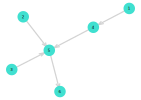

In [15]:
causal_order = K2Search([1,2,3,4,5,6])

g = fit(causal_order,vars,data)

nodelabel = collect(1:nv(g))

gplot(g,nodelabel=nodelabel)

### 2. Algorithm Hill Climbing with the graph obtained throught K2 algorithm

Initial;-318.8131154034957
-318.4367454889591


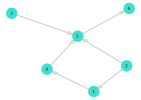

In [17]:
test_local_3 = LocalDirectedGraphSearch(g,1000)

grafo=fit(test_local_3,vars,data)

gplot(grafo,nodelabel=nodelabel)


### 3. Creating a Bayesian structure with statistics

#### 3.1 Creating tree structure with mutual information metric

In [18]:
pair_dict = fill_dictionary(vars)
mutual_information_dict=get_mutual_information(data,vars,pair_dict)
sort(mutual_information_dict, byvalue=true, rev=true)

OrderedDict{Tuple, Float64} with 15 entries:
  (Variable(:p, 2), Variable(:c, 2))  => -0.221212
  (Variable(:p, 2), Variable(:u, 3))  => -0.475056
  (Variable(:c, 2), Variable(:u, 3))  => -0.635467
  (Variable(:p, 2), Variable(:a, 4))  => -0.742593
  (Variable(:c, 2), Variable(:a, 4))  => -0.854534
  (Variable(:g, 5), Variable(:c, 2))  => -0.900341
  (Variable(:g, 5), Variable(:p, 2))  => -1.20744
  (Variable(:g, 5), Variable(:u, 3))  => -1.46066
  (Variable(:u, 3), Variable(:a, 4))  => -1.90893
  (Variable(:g, 5), Variable(:a, 4))  => -2.14457
  (Variable(:c, 2), Variable(:t, 11)) => -2.32615
  (Variable(:p, 2), Variable(:t, 11)) => -2.33188
  (Variable(:u, 3), Variable(:t, 11)) => -5.31967
  (Variable(:g, 5), Variable(:t, 11)) => -6.00579
  (Variable(:a, 4), Variable(:t, 11)) => -7.18501

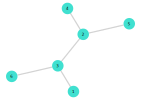

In [19]:
graph_t = create_graph(mutual_information_dict,vars)
nodelabel= 1:nv(graph_t)
gplot(SimpleGraph(graph_t),nodelabel=nodelabel)

#### 3.2 Get independant variables in tree structure

In [20]:
independant_vertex = get_independent_edges(data,vars,graph_t)

Dict{Tuple, Bool} with 2 entries:
  (3, 4) => 1
  (3, 5) => 1

#### 3.4 Creating an initial graph with the independent vertices found

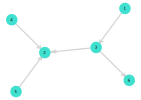

In [21]:
initial_graph = SimpleDiGraph(6)
add_edge!(initial_graph,3,2)
add_edge!(initial_graph,4,2)
add_edge!(initial_graph,5,2)
add_edge!(initial_graph,3,6)
add_edge!(initial_graph,1,3)
gplot(initial_graph,nodelabel=nodelabel)

#### 3.4.1 Hill Climbing using with restricted edges at initial_graph

Initial;-398.8838760298033
Any[(3, 6)]
Any[(3, 6), (1, 3)]
Final: -398.8838760298033


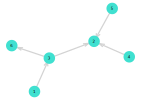

In [46]:
test_local_2 = LocalDirectedGraphSearch(initial_graph,100)
directed_edges_2 = [(5,2),(4,2),(3,2)]

grafo=fit(test_local_2,vars,data,directed_edges_2)
gplot(grafo,nodelabel=nodelabel)

#### 3.5.2 Hill Climbing at initial_graph

Initial;-398.8838760298033
-388.585037670792
-387.618565373383
-375.0044515687348
-358.3568771246125
-353.16400634463224
-352.79649468011706
-344.524487251015
-343.73144502975447
-341.6573553031466
-341.4521326058532
-338.9310330354706
-337.66512249170717
-337.186827004067
-325.2059243109894
-323.25388334648954


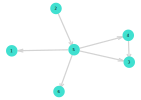

In [23]:
test_local_2 = LocalDirectedGraphSearch(initial_graph,300)
directed_edges_2 = [(5,2),(4,2),(3,2)]

grafo=fit(test_local_2,vars,data)
gplot(grafo,nodelabel=nodelabel)

#### 3.5 Creating an initial graph with the independent vertices found

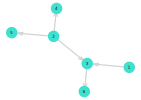

In [24]:
initial_graph_2 = SimpleDiGraph(6)
add_edge!(initial_graph_2,2,5)
add_edge!(initial_graph_2,2,4)
add_edge!(initial_graph_2,2,3)
add_edge!(initial_graph_2,3,6)
add_edge!(initial_graph_2,1,3)
gplot(initial_graph_2,nodelabel=nodelabel)

#### 3.5.1 Hill Climbing using with restricted edges at initial_graph_2

Initial;-391.8714622351093
Any[(3, 6)]
Any[(3, 6), (1, 3)]
Any[(3, 6), (1, 3), (3, 1)]
Final: -391.07193398623247

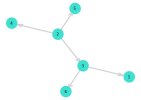

In [27]:
test_local_3=LocalDirectedGraphSearch(initial_graph_2,100)
directed_edges_3 = [(2,5),(2,3),(2,4)]

grafo=fit(test_local_3,vars,data,directed_edges_3)
gplot(grafo,nodelabel=nodelabel)

#### 3.5.2 Hill Climbing at initial graph_2

Initial;-391.8714622351093
-381.572623876098
-368.9327427622216
-368.34670663035774
-355.73259282570956
-354.9680618719642
-342.3212956640244
-341.6285977376086
-332.3985949297212
-327.6690291576128
-326.5921821754307
-325.3670917506402
-323.79287984722225
-323.25388334648954


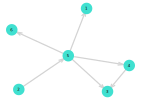

In [26]:
test_local_3=LocalDirectedGraphSearch(initial_graph_2,1000)
directed_edges_3 = [(2,5),(2,3),(2,4)]

grafo=fit(test_local_3,vars,data)
gplot(grafo,nodelabel=nodelabel)

In [87]:
# # subcount=statistics(vars, grafo, data)

# for e in edges(grafo)
#     println("add_edge!(graph,",e.src,",",e.dst,")")
# end

In [88]:
# # subcount=statistics(vars, grafo, data)

# index = 1

# for row in eachrow(subcount)
    
#     println("i_before: ",row)
#     master,c,u,a = 1,1,1,1

#     for i in eachrow(row[1])
#         i=i./56
#         if index == 2
#             for (k,value) in enumerate(i)
#                 println("(p=",k," , c=",c," , u=",u," , a=",a,") => ",round(value;digits = 3),",")
               
#             end
            
            
#             if c%2==0
#                 c=0
#             end
            
           
#             if master%2==0
#                 u += 1
                
#             end
            
#             if master%6==0
#                 u=1
#                 a+=1
#             end
        
            
# #             println(master)
#            c+=1
#            master+=1
#         end
#     end
    
#     index += 1
# end